In [2]:
import re
import pandas
import matplotlib.pyplot as plt
import joblib

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# necessary nltk downloads

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("vader_lexicon", quiet=True)

True

In [4]:
# loading csv file
df = pandas.read_csv("../data/reviews.csv", on_bad_lines="skip")

In [5]:
def preprocessing(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()

    # removing urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # removing HTML
    html_pattern = re.compile('<.*?>')
    text = html_pattern.sub(r'', text)

    # removing punctuations
    punctuation_pattern = re.compile(r'[^\w\s]')
    text = punctuation_pattern.sub(r'', text)

    # tokenization
    text = word_tokenize(text)

    # removing stopwords
    stop_words_set = set(stopwords.words("english"))
    text = [word for word in text if word not in stop_words_set]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    # sticking sentence back and returning
    return ' '.join(text)


In [6]:
# reprocessing reviews
df["Processed"] = df["Review"].apply(preprocessing)
print(df.head()["Processed"])

0                                               boring
1                                                bravo
2                                                  goo
3    great course recommend especially business man...
4                         one useful course management
Name: Processed, dtype: object


In [7]:
# sentiment analysis using vader

vader = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    # calculating polarity score
    score = vader.polarity_scores(text)

    # extracting only the 'neg', 'neu', 'pos'
    relevant_scores = {k: score[k] for k in ('neg', 'neu', 'pos')}

    # finding key with highest value
    max_sentiment = max(relevant_scores, key=relevant_scores.get)
    return max_sentiment

In [8]:
# applying rule based sentiment analysis(VADER)
df["Sentiment"] = df["Processed"].apply(analyze_sentiment)
print(df.head(5)["Sentiment"])

0    neg
1    neu
2    neu
3    pos
4    neu
Name: Sentiment, dtype: object


In [9]:
# feature extraction using TF-IDF Vectorization

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df["Processed"]).toarray()
Y = df["Sentiment"]

In [11]:
# saving TfidfVectorizer
joblib.dump(tfidf_vectorizer, "../models/tfidf_vectorizer.joblib")

['../models/tfidf_vectorizer.joblib']

In [12]:
# splitting dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [13]:
# model training

model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [14]:
# saving model

joblib.dump(model, "../models/logistic_regression_model.joblib")

['../models/logistic_regression_model.joblib']

In [15]:
# evaluating model

prediction_result = model.predict(X_test)
eval_result = classification_report(Y_test, prediction_result)
print(eval_result)

              precision    recall  f1-score   support

         neg       0.87      0.11      0.19       541
         neu       0.92      0.95      0.93     24240
         pos       0.93      0.90      0.92     17315

    accuracy                           0.92     42096
   macro avg       0.90      0.65      0.68     42096
weighted avg       0.92      0.92      0.92     42096



<Figure size 800x600 with 0 Axes>

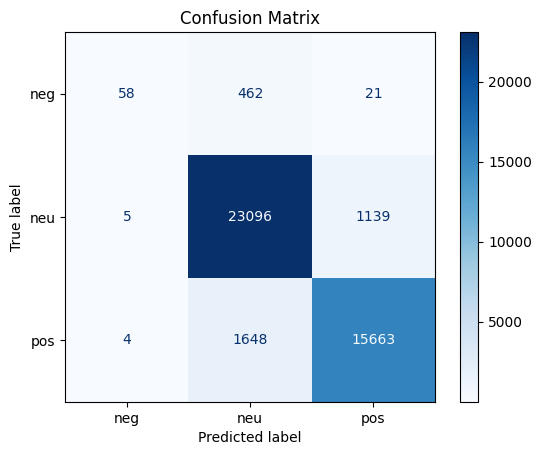

In [16]:
# confusion matrix

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

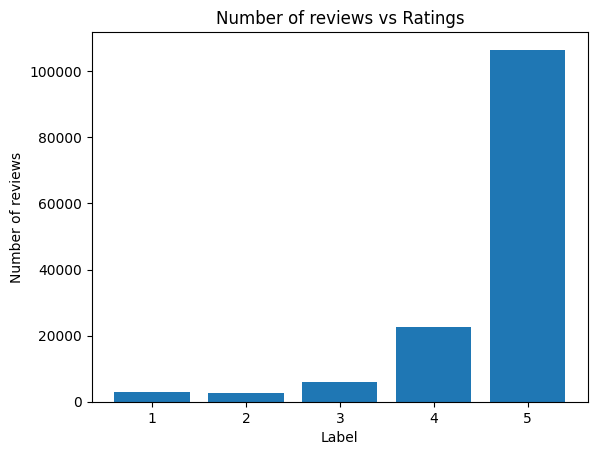

In [17]:
# ratings vs no. of reviews
label_counts = df.groupby("Label").size()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.title("Number of reviews vs Ratings")

plt.show()

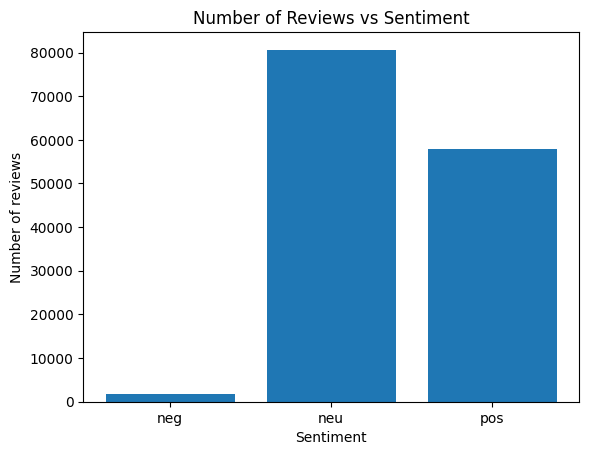

In [18]:
# sentiment vs. no of reviews
sentiment_counts = df.groupby("Sentiment").size()

plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Number of reviews")
plt.title("Number of Reviews vs Sentiment")

plt.show()